<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
import os

In [3]:
os.getcwd()

'C:\\Users\\SKrishna\\Documents\\GitHub\\DS-Unit-4-Sprint-1-NLP\\module2-vector-representations'

In [4]:
from bs4 import BeautifulSoup
import requests

df = pd.read_csv('data\job_listings.csv')
##### Your Code Here #####
#raise Exception("\nThis task is not complete. \nReplace this line with your code for the task.")
                


In [5]:
parsed_data = []
for desc in df['description']:
    soup = BeautifulSoup(desc, "html.parser")
    parsed_data.append(soup.get_text()[2:-1])

In [6]:
df['parsed_desc'] = parsed_data

In [7]:
df.head()

,Unnamed: 0,description,title,parsed_desc
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements:\nConceptual understanding in...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description\n\nAs a Data Scientist 1, you ..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA \xe2\x80\x93 multiple locations\...


In [8]:
df['parsed_desc'] = df['parsed_desc'].str.replace("\\", " ").str.replace(" n ", "")

In [9]:
df.head()

,Unnamed: 0,description,title,parsed_desc
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: nConceptual understanding in...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job DescriptionnAs a Data Scientist 1, you wil..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA xe2 x80 x93 multiple locations ...


## 2) Use Spacy to tokenize the listings 

In [10]:
##### Your Code Here #####
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens 

#raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

In [11]:
#import base
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

#NLP libraries
import spacy
from spacy.tokenizer import Tokenizer


nlp = spacy.load("en_core_web_lg")


In [12]:
df['tokens'] = df['parsed_desc'].apply(tokenize)

In [13]:
df['tokens'].head()

0    [job, requirements, nconceptual, understanding...
1    [job, descriptionnas, a, data, scientist, 1, y...
2    [as, a, data, scientist, you, will, be, workin...
3    [4969, 6756, a, monthcontractunder, the, gener...
4    [location, usa, xe2, x80, x93, multiple, locat...
Name: tokens, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [14]:
##### Your Code Here #####


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vect = CountVectorizer(stop_words = 'english')

vect.fit(df['parsed_desc'])

#raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [15]:
dtm = vect.transform(df['parsed_desc'])

In [16]:
type(dtm.todense())

numpy.matrix

In [17]:
print(vect.get_feature_names())

['00', '000', '000npay', '02115', '03', '0356', '04', '062', '06366', '08', '0ndeep', '10', '100', '1000', '1001', '1008', '100k', '100x', '105', '1079302nwho', '1082692', '10b', '10ms', '10x', '11', '110k', '112', '114157802', '12', '120', '125', '126', '130', '1315', '1324b', '138', '14', '140', '15', '150', '15000', '159m', '16', '1605', '165', '169334brnjob', '17', '170', '17b', '18', '180', '180008jqnzurich', '18b', '19', '190', '190007jin', '19000bn4n', '19000c1kn', '19004162', '1901744', '1904', '1904labs', '1905', '19050', '1938', '1944', '1967', '1971', '1975', '1979', '1988', '199', '1994', '1999', '1b', '1st', '1strategy', '1tb', '20', '200', '2000', '200020183', '200041695', '2004', '2008', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2019nposition', '2020', '2050', '20nflsa', '21', '210', '2145', '2272', '24', '24m', '25', '250', '25256', '26', '260', '27', '28', '2nd', '2x', '30', '300', '30328', '30bn', '30k', '31', '317', '320', '3201', '3201

In [18]:
print(dtm)

  (0, 233)	1
  (0, 671)	1
  (0, 712)	1
  (0, 940)	1
  (0, 1498)	1
  (0, 1556)	1
  (0, 1642)	1
  (0, 1733)	1
  (0, 2123)	1
  (0, 2189)	1
  (0, 2225)	1
  (0, 2564)	1
  (0, 2698)	1
  (0, 3049)	2
  (0, 3080)	1
  (0, 3240)	1
  (0, 3267)	1
  (0, 3374)	1
  (0, 3477)	1
  (0, 3594)	1
  (0, 3603)	1
  (0, 3747)	1
  (0, 3860)	1
  (0, 3871)	1
  (0, 4433)	1
  :	:
  (425, 9599)	1
  (425, 9605)	1
  (425, 9637)	1
  (425, 9739)	1
  (425, 9767)	1
  (425, 9802)	1
  (425, 9812)	2
  (425, 9845)	2
  (425, 9874)	1
  (425, 9883)	1
  (425, 9924)	1
  (425, 9944)	1
  (425, 9983)	1
  (425, 10005)	1
  (425, 10053)	1
  (425, 10127)	1
  (425, 10151)	6
  (425, 10157)	1
  (425, 10161)	1
  (425, 10165)	1
  (425, 10189)	5
  (425, 10202)	2
  (425, 10238)	3
  (425, 10309)	5
  (425, 10323)	2


In [19]:
#get word count for each job listing
dtm = pd.DataFrame(dtm.todense(),columns=vect.get_feature_names())

In [20]:
dtm

,00,000,000npay,02115,03,0356,04,062,06366,08,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)



In [22]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['parsed_desc'],batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens_spacy'] = tokens

## 4) Visualize the most common word counts

In [23]:
##### Your Code Here #####

import squarify

def count(docs):
    word_counts = Counter() #initiate variable
    appears_in = Counter() #initiate variable
    
    total_docs = len(docs) #length of docs
    
    for doc in docs:
        word_counts.update(doc) #what does update do here
        appears_in.update(set(doc)) #what does update and set do here
    
    temp = zip(word_counts.keys(), word_counts.values()) 
    
    wc = pd.DataFrame(temp, columns = ['word','count']) #create new DF
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False) #rank is a method, highest to lowest order
    total = wc['count'].sum()
    
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')
    



#raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

In [24]:
wc = count(df['tokens_spacy'])

In [25]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
7,data,421,3855,1.0,0.028102,0.028102,0.988263
159,xe2,315,1413,2.0,0.010300,0.038402,0.739437
259,x80,314,1404,3.0,0.010235,0.048637,0.737089
97,business,303,1038,4.0,0.007567,0.056204,0.711268
54,experience,374,1032,5.0,0.007523,0.063727,0.877934


In [26]:
wc[wc['rank'] <= 200]['cul_pct_total'].max()

0.361112123575766

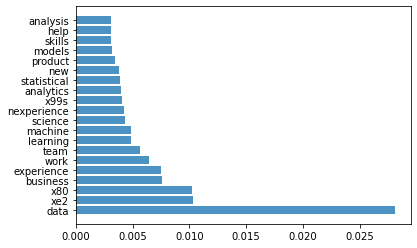

In [27]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

plt.barh(width=wc_top20['pct_total'], y=wc_top20['word'], alpha=.8 )
#plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [28]:
##### Your Code Here #####

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = 'english',
                         ngram_range = (1,2),
                         min_df = 5,
                        max_df = 0.6,
                       )

dtm = tfidf.fit_transform(df['parsed_desc'])


# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
print(dtm.shape)
dtm.head()

#raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

(426, 6247)


,000,000 employees,10,10 years,100,100 000,100 companies,100 countries,11,12,...,years industry,years professional,years related,years relevant,years work,years working,years xe2,yes,york,york city
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [29]:
##### Your Code Here #####

from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

#raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [30]:
resume = [" Data Scientist with masters degree in systems engineering, created a airbnb prediction dash app familiar with KNN multivariate regression AB testing and AWS EC2"]

In [31]:
new = tfidf.transform(resume)

In [32]:
nn.kneighbors(new.todense())

(array([[1.35406422, 1.35857147, 1.36347946, 1.36347946, 1.36631023]]),
 array([[313, 330, 303,  58, 222]], dtype=int64))

In [33]:
df.iloc[313]

Unnamed: 0                                                    313
description     b'<div><div><div>Hinge Health\xe2\x80\x99s mis...
title                                  Statistical Data Scientist
parsed_desc     Hinge Health xe2 x80 x99s mission is to improv...
tokens          [hinge, health, xe2, x80, x99s, mission, is, t...
tokens_spacy    [hinge, health, xe2, x80, x99s, mission, impro...
Name: 313, dtype: object


## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 